
# Autoencoder and Varational Autoencoder (VAE) Exercise
---


## What is an Autoencoder

To know what a VAE is we must first understand what an Auto-Encoder is...

An Auto-Encoder is a type of neutal network used in unspervised learing. Unsupervised learing is a form of machine learning where you provide the model with data, **BUT NOT LABELS!!!**. -- Well sort of. We kind of cheet. We use the input data as the label.

To train an Autoencoder we push the input data through layers of decresing size. This portion is know as the *endoder*. The encoder attempts to compress the input data to a significantly lower dimentioanlly that the original input data. This is known as an *embedding vector*. We then take this embedding vector and *decode* it by passing it through layers of increasing size (a mirror image of the encoder) until we're back to same dimentionally as the input data.

![autoencoder](resources/autoencoder_0.png)

The network then determins a recontruction loss by comparing the original input to the reconstruction. Once trained the encoder has learned a mapping from input space to what we call a *latent space*. The decoder has leaned to mapping back from latent space to input space.

- *intuateivally you can think of this as 'lossy compression*

Here are some great material on Autoencoders :

- https://medium.com/@Terrybroad/autoencoding-blade-runner-88941213abbe
- https://www.youtube.com/watch?v=H1AllrJ-_30
- https://www.youtube.com/watch?v=GWn7vD2Ud3M
- https://blog.keras.io/building-autoencoders-in-keras.html

One major drawback of an Autoencoder is the inability to meaningfully sample from the latent space. That is to say there is no structure in the embedding space. Similar instances are not nessessatlly locaded close to eachother in the latent space.

**Enter stage right: VAE**

A VAE implementes a second part to the loss functions. Instead of just attempting to recreate the input image there is an additional loss associated with the distribution of the elements within the embedding space. This new loss is calculated using the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL divergence). 

![VAE](resources/vae.png)

At a high level the reconstrucion encourages the model to produce more realistic outputs, and the KL divergence attempts to keep the elements within the embedding as independant as possiable. A well trained VAE should reach a happy middle ground between good reconstruction and a structured latent space.

Nothing in the world is free though. The reconstructions made by a VAE are usually less accurate than that made by an autoencoder. For some more reading on VAE here are some links.

- https://arxiv.org/abs/1312.6114
- https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
- https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.
- https://ermongroup.github.io/cs228-notes/extras/vae/


## Your first task task is to implement an Autoencoder to reproduce emoji's


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import load_local_data
from random import choice
import numpy as np

r = lambda x: round(x*1e4)/1e4

def mk_ax(*args):
    ax = plt.subplot(*args)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
def make_batch (data, batch_size):
    idxs = np.random.choice(len(data), size=batch_size)
    return data[idxs]

### Load Images and plot some examples

Images are loaded as rgb the converted to grayscale (or not, you choose by running the appropriate cell.

In [2]:
emojis_train, emojis_test = load_local_data("./emoji_data")

In [3]:
def display_sample(dataset, samples=10):
    plt.figure(figsize=(samples,1))
    
    for i in range(samples):
        mk_ax(1, samples, i + 1)
        to_plot = choice(dataset)
        plt.imshow(to_plot)


def rgb2gray(data):
    gray = []
    for rgb in data:
        # Magic numbers taken from opencv's rbg2gray method
        temp = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
        temp = np.expand_dims(temp, axis=2)
        gray.append(temp)
    gray = np.asarray(gray)
    return gray

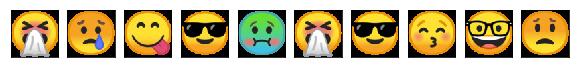

In [4]:
display_sample(emojis_train)

In [5]:
def normalise (dataset):
    result = dataset.astype(np.float32) / 255.
    return result

def preprocess (dataset, to_gray=False):
    data = None
    if to_gray:
        data = rgb2gray(dataset)
        data = normalise(dataset)
    else:
        data = normalise(dataset)
    flat = data.reshape( (len(data), -1) )
    return flat

In [6]:
x_train = preprocess(emojis_train, to_gray=False)
x_test  = preprocess(emojis_test,  to_gray=False)

### Lets define the Autoencoder model
Below is a drawing of the model.

![Vae_schematic](resources/Autoenc.jpg)

---

### Some hyperparams

In [7]:
import tensorflow as tf
from tensorflow import layers

In [8]:
72**2

5184

In [12]:
batch_size      = 5
hidden_size     = 256
embedding_dim   = 2
input_size_flat = x_train.shape[-1]

tf.reset_default_graph()

with tf.variable_scope("encoder"):
    input_ = tf.placeholder(tf.float32, shape=(None, input_size_flat))
    h1     = layers.dense(input_, hidden_size, activation=tf.nn.relu)

# Autoencoder
# with tf.variable_scope("embedding"):
#     z = layers.dense(h1, embedding_dim, activation=None)
    
    
# # VAE 
with tf.variable_scope("embedding"):
    mu        = layers.dense(h1, embedding_dim, activation=None)
    log_sigma = layers.dense(h1, embedding_dim, activation=None)
    z_hat     = tf.random_normal(shape=tf.shape(mu))
    z         = mu + tf.exp(log_sigma / 2.) * z_hat

with tf.variable_scope("decoder"):
    h2     = layers.dense(z, hidden_size, activation=tf.nn.relu)
    logits = layers.dense(h2, input_size_flat, activation=None)
    # Sigmoid to get into [0,1].
    output = tf.sigmoid(logits)

# VAE Loss    
with tf.variable_scope("loss"):
    # 1. Reconstruction loss: How far did we get from the actual image?
    rec_loss = tf.reduce_sum(tf.square(input_ - output), axis=1)
    rec_loss = tf.reduce_mean(rec_loss)


    # 2. KL-Divergence: How far from the "true" distribution of z's is
    #                   our parameterised z?

    # TODO: Explain this a bit.
    div_loss = tf.reduce_sum( 0.5 * (tf.exp(log_sigma) + tf.square(mu) - 1. - log_sigma) , axis=1)
    div_loss = tf.reduce_mean(div_loss)
    loss = rec_loss + div_loss

# Autoencoder Loss
# with tf.variable_scope("loss"):
#     # 1. Reconstruction loss: How far did we get from the actual image?
#     loss = tf.reduce_sum(tf.square(input_ - output), axis=1)
#     loss = tf.reduce_mean(loss)

# L2 Loss
with tf.variable_scope("loss"):
    # L2
#     l2 = tf.nn.l2_loss(z)
#     l2 = tf.reduce_mean(l2)
    
    # 1. Reconstruction loss: How far did we get from the actual image?
    loss = tf.reduce_sum(tf.square(input_ - output), axis=1)
    loss = tf.reduce_mean(loss)

In [40]:
hidden_size     = 256
embedding_dim   = 2
input_size_flat = x_train.shape[-1] # 72*72*3

tf.reset_default_graph()

with tf.variable_scope('input'):
    x = tf.placeholder(tf.float32, shape=(None, input_size_flat))

with tf.variable_scope('h1'):
    h1 = layers.dense(x, units=hidden_size, activation=tf.nn.relu)

with tf.variable_scope('z'):
    z = layers.dense(h1, units=embedding_dim, activation=None)

with tf.variable_scope('h2'):
    h2 = layers.dense(z, units=hidden_size, activation=tf.nn.relu)

with tf.variable_scope('output'):
    logits = layers.dense(h2, units=input_size_flat, activation=None)
    output = tf.sigmoid(logits)
    
with tf.variable_scope('loss'):
    loss = tf.reduce_sum(tf.square(x - output), axis=1)
    loss = tf.reduce_mean(loss)
#     loss = tf.reduce_mean((output - x)**2)
    

In [41]:
# opt      = tf.train.AdamOptimizer(learning_rate=1e-3)
# train_op = opt.minimize(loss)
# steps    = 100 * len(x_train)

# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())

# for i in range(steps):
#     feed = { input_: make_batch(x_train, batch_size)
#            }
#     _, cur_train_loss = sess.run([train_op, loss]
#                               , feed_dict = feed)
    
#     if i % 1000 == 0:
#         feed = { input_: make_batch(x_test, batch_size) }
#         val_loss = sess.run(loss, feed_dict=feed)
#         print(f"Step {i}: {r(val_loss)}, train_loss: {r(cur_train_loss)}")

In [42]:
steps = 3000
batch_size = 5
learning_rate = 0.01

# Specify the optimizer:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

# Start a tensorflow session:
sess = tf.Session()

train_results = list()
val_results = list()

# Initialise all variables (to random starting values)

init = tf.global_variables_initializer()
sess.run(init)

# Our training loop. Train the model for the number of steps specified.
for cur_step in range(steps):

   # We get our sample batch
   cur_x = make_batch(x_train, batch_size)

   # Run a train step
   _, cur_loss = sess.run([train_step, loss], feed_dict={x: cur_x})

   # Save the loss
   train_results.append({'loss': cur_loss, 'step': cur_step})

   # print('Step: {}; Training loss: {}'.format(cur_step, cur_loss))

   # Every 100 steps, run on the validation set:
   if cur_step % 100 == 0:

       val_x = make_batch(x_test, batch_size=batch_size)

       cur_val_loss, = sess.run([loss], feed_dict={x: val_x})

       # Salve the loss
       val_results.append({'val_loss': cur_val_loss, 'step': cur_step})

       print('Step: {}; Validation loss: {}'.format(cur_step, cur_val_loss))


print('Step: {}; Validation loss: {}'.format(cur_step, cur_loss))

# Use pandas to turn our stored losses
# train_results = pd.DataFrame(train_results)
# val_results = pd.DataFrame(val_results)

Step: 0; Validation loss: 2090.30029296875
Step: 100; Validation loss: 1911.7132568359375
Step: 200; Validation loss: 1955.0308837890625
Step: 300; Validation loss: 1995.8538818359375
Step: 400; Validation loss: 2904.151123046875
Step: 500; Validation loss: 2446.17529296875
Step: 600; Validation loss: 1982.511474609375
Step: 700; Validation loss: 2459.611572265625
Step: 800; Validation loss: 1722.9840087890625
Step: 900; Validation loss: 1938.733154296875
Step: 1000; Validation loss: 2106.67529296875
Step: 1100; Validation loss: 2556.951171875
Step: 1200; Validation loss: 2129.540771484375
Step: 1300; Validation loss: 1962.761962890625
Step: 1400; Validation loss: 2030.885986328125
Step: 1500; Validation loss: 1797.2349853515625
Step: 1600; Validation loss: 2273.94775390625
Step: 1700; Validation loss: 1892.5943603515625
Step: 1800; Validation loss: 1919.881103515625
Step: 1900; Validation loss: 1982.1109619140625
Step: 2000; Validation loss: 2508.51025390625
Step: 2100; Validation los

# Look at then reconstruction 

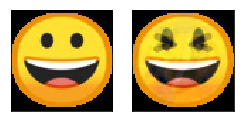

In [25]:
im_dim = (72, 72, 3)

plt.figure(figsize=(4,2))

img    = choice(x_test)
mk_ax(1, 2, 1)
pimg = img.reshape(im_dim)
plt.imshow( pimg )

autoencoded = sess.run( tf.squeeze(output), feed_dict = {input_: [img]})
# print(np.min(autoencoded), np.max(autoencoded))
mk_ax(1, 2, 2)
autoencoded = autoencoded.reshape(im_dim)
_ = plt.imshow( autoencoded )

# Lets look at how the Autoencoder has clustered the emojis

In [26]:
from skimage.transform import resize
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

In [33]:
def get_embeddings(dataset):
    for img in dataset:
        z_ = sess.run( tf.squeeze(z), feed_dict = { input_: [img]} )
        yield z_

        
def plot_embeddings(zs, images):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111)
    
    for z_, image in zip(zs, images):
        z1, z2 = z_
        
        bb   = Bbox.from_bounds(z1, z2, 2.5, 2.5)
        bb   = TransformedBbox(bb, ax.transData)
        bbim = BboxImage(bb) 
        bbim.set_data(image)
        ax.add_artist(bbim)
    
    mmax = np.max(zs)
    mmin = np.min(zs)
    
    ax.set_xlim(mmin, mmax)
    ax.set_ylim(mmin, mmax)
    ax.set_title("Images on latent space")
    plt.show()

In [34]:
x_all      = np.vstack([x_train, x_test])
emojis_all = np.vstack([emojis_train, emojis_test])

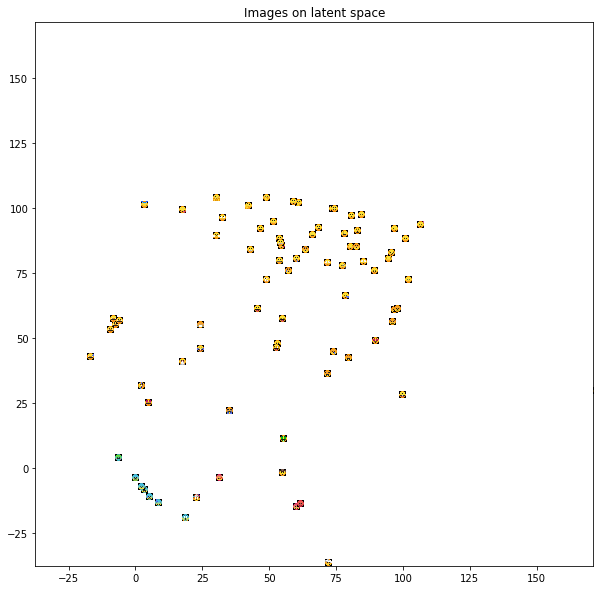

In [35]:
plot_embeddings( list(get_embeddings(x_all)), emojis_all )
# plot_embeddings( list(get_embeddings(x_test)), emojis_test )

**Do you notice anything?**

If you've trained on colored images maybe you notice emojis of the same color tend to appear in the similar areas. Maybe you can try to make the network a bit more complex, maybe even convolutional! 

# Sampling

Here we are just picking a random number and reconstructing it with the **decoder**. Have a few goes, see what you find. You can also try to eyeball some vector from the above plot and pass it through the **deocder**.

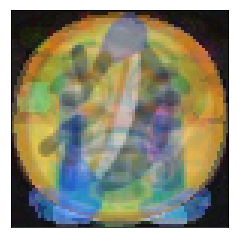

In [36]:
z_ = np.random.normal(size=(embedding_dim,))
im = sess.run(tf.squeeze(output), feed_dict = {z: [z_]})
mk_ax(1,1,1)
_ = plt.imshow(im.reshape(im_dim))

## Interpolation

This next step we will select 2 random emojis, computer their reconstructions and interpolate between them.

z1: [99.63552 86.69712]
z2: [22.867334 44.6073  ]


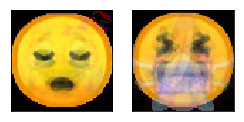

In [37]:
image1 = choice(x_test)
image2 = choice(x_test)

out1, z1 = sess.run([output, tf.squeeze(z)], feed_dict={input_: [image1] })
out2, z2 = sess.run([output, tf.squeeze(z)], feed_dict={input_: [image2] })


plt.figure(figsize=(4,2))

mk_ax(1, 2, 1)
plt.imshow(out1.reshape(im_dim))

mk_ax(1, 2, 2)
_ = plt.imshow(out2.reshape(im_dim))


print(f"z1: {z1}")
print(f"z2: {z2}")

In [38]:
# This is a little code to make a small gif of the interpolation. Unfortunately we could not get
# it to work before the workshop :-( so we did the static interpolation using matplotlib

# import matplotlib.animation as animation
# from IPython.display import HTML
# from matplotlib import rc

# # enable auto-show of animations
# rc('animation', html='html5')


# def imshow(img, fig=None, **kwargs):
#     fig = fig if fig is not None else pl.gcf()
#     ax = fig.add_axes([0, 0, 1, 1])
#     ax.axis('off')
#     return ax.imshow(img) 


# FRAMES = 100

# images = []
# for i in range(FRAMES):
#     t  = i / FRAMES
#     zn = t * z1 + (1-t) * z2
    
#     image = sess.run(tf.squeeze(output), feed_dict = { z: [zn] })
#     image = image.reshape(im_dim)
#     images.append(image)

# fig = plt.figure(0, figsize=(3, 3))
# img_ax = imshow(images[0], animated=True, fig=fig)

# def updatefig(n):
#     img_ax.set_array(images[n])
#     return img_ax,

# plt.close(fig)
# animation.FuncAnimation(fig, updatefig, frames=FRAMES, interval=5000 / FRAMES,
#                         blit=True) 

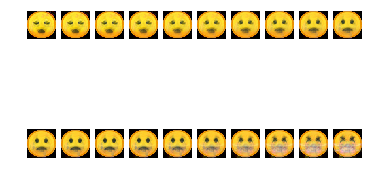

In [39]:
frames = 20
dx = (z2[0] - z1[0]) / frames
dy = (z2[1] - z1[1]) / frames
images = []
for i in range(frames):
    plt.subplot(2, 10, i+1)
    zn = [z1[0] + (dx*i) , z1[0] + (dy*i)]
    
    image = sess.run(tf.squeeze(output), feed_dict = { z: [zn] })
    image = image.reshape(im_dim)
    plt.imshow(image)
    plt.gca().axis('off')


# Extra credit!!!

Congratulations if you've got this far!!!

You may have noticed the interpolations generated via the Autoencoder is pretty crazy. A attempt to make the interpolation more meaningful is the **Variational Autoencoder**. 

> *well if we can't meaningfully sample from the latent space discovered via an Autoencoder...the we'll try to shoe-horn the latent space into a shape we CAN sample from.*

---

The latent space discovered by the Autoencoder clearly clusters similar instances, but imagin walking from one cluster to another...say:


|![kiss](emoji_data/train/angry-face.jpg)| to |![kiss](emoji_data/train/smiling-face-with-heart-shaped-eyes.jpg) |
|:------------- |:-------------:|:-------------:|

You would hope as you move from **angry** to **love-eyes** you get a smooth transition. However, as you may have noticed in the Autoencoder exercise this is not the case. This is because when discovering the latent space a vanilla Autoencoder is free to *choose* the vector that best allows the decoder to reconstruct the input without considering the relationship between the clusters. Look at the following image 

![latent_space](resources/lat_space.jpg)

Moving from **A** to **B** there is a lot of space where the decoder needs to attempt to reconstruct similar instances. Interpolation will occure slowly and there will be a lot of noise. The decoder probably will not be able to cook up a meaningful reconstruction for evey step along **AB**. Whereas **B** to **C** the space is very dense and moving along **BC** will result in very rapid change.

**What if** we try to constrain the z vector. We may make the decoder work harder but we gain a more structured latent space from which to select the z vector.

Our first attempt will be to just constrain the z using L2 regularization.

```python
# For You To Do:  
#         - Jump back to the model definition and modify 
#           the loss code to inculde L2 regularization
#         - Retrain and run through to the Interpolation shep
```

**What did you notice!!!**

---
**VAE, at long last.**

A VAE attempts to confine the the latent vector to an assumed probibility distribtion (This is known as the $prior$). This prior in the case of the [*canonical* VAE](https://arxiv.org/pdf/1312.6114.pdf) is a normal distribution with zero mean ($\mu = 0$) and unit variance ($\sigma^2 = 1$), but in theory I could be anything you want.

$p(z) = Normal(0,1)$

The way we apply this constraint is with the [Kullback-Leibler Divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained). KL-divergence is a measure of how much 2 distributions align with one and other. By using KL-divergence we essentially *shoe horn* the latent vector into some distribution we can sample from, in our case a Normal Distribution with zero mean and unit variance.

The KL-Divergence is given by:

$KL(p || q) = \sum^N_{i=1} p(x_i) log \frac{p(x_i)}{q(x_i)}$

where $p$ is the our discovered distribution (in our case, $z$) and $q$ is our zero mean unit variance distribution we're comparing to. It is a bit challanging getting from this formula to the code implementation so we have done it for you. Replace the `loss` in your model with this.

---

```python
with tf.variable_scope("loss"):
    # 1. Reconstruction loss: How far did we get from the actual image?
    rec_loss = tf.reduce_sum(tf.square(input_ - output), axis=1)
    rec_loss = tf.reduce_mean(rec_loss)
    
    
    # 2. KL-Divergence: How far from the "true" distribution of z's is
    #                   our parameterised z?
    
    div_loss = tf.reduce_sum( 0.5 * (tf.exp(log_sigma) + tf.square(mu) - 1. - log_sigma) , axis=1)
    div_loss = tf.reduce_mean(div_loss)
    
    loss = rec_loss + div_loss
```


**We're almost there**

Now we're show-horning the latent space into a normal distribution we need to sample from it. Naively we could sample using `z_mean` and `z_log_var` directly.

$Sample(\mu(Embedding), \sigma^2(Embedding))$

**But wait, cool your jets! I here you say.** *NNs use gradient decent to optimize an error. Sure applying a constraint to the latent space sounds plausable, but how the hell can I differentiate with respect to a randomly sampled variable.*

Excellent observation! This is the special trick that occurs within a VAE. It turns out that the above $Sample$ step has an equilivant that **IS** differentiable. 

$$z = \mu + e^{\log{(\sigma / 2)}} \epsilon$$

where $\epsilon$ is a random vector sampled from $p(z) = Normal(0,1)$.


```python
# For You To Do:  
#         - Jump back to the model definition and modify 
#           the embedding code to include the sampling step.
#         - Retrain and run through to the Interpolation step

# It should look something like this:
# VAE Embedding With Sampling
with tf.variable_scope("embedding"):
    mu        = 
    log_sigma = 
    epsilon   = 
    z         = 
```


Finally try and run the steps from **Training** to **Interpolation** to see what happens.
The final model should resemble this.

![VAE](resources/vae_resize.jpg)